
## Projeto data science
#### Análise de dados Premier League 2023-24
#### Dupla: Henrique Melo (hcm) e Philippe Menge (pmal)



Definição do dataset

In [69]:
%pip install seaborn


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 220.2 kB/s eta 0:00:02
   -------- ------------------------------ 61.4/294.9 kB 328.2 kB/s eta 0:00:01
   --------------------------------- ------ 245.8/294.9 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [38]:
df = pd.read_csv('PL23.csv')

In [39]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 314.8+ KB


# Pré-processamento dos dados

Removemos todas as colunas relacionadas a apostas menos as médias, máximos e mínimos. 
Removemos também relacionadas a divisão da partida, data e hora.

In [40]:

unused_columns = ['Div','Date','Time','Referee','B365>2.5','B365<2.5','P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA','B365H','B365D','B365A', 'BWH','BWD','BWA','IWH','IWD','IWA','PSH','PSD','PSA','WHH','WHD','WHA','VCH','VCD','VCA']
df.drop(unused_columns, axis=1, inplace=True)
df.head()


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HY,AY,HR,AR,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Burnley,Man City,0,3,A,0,2,A,6,17,...,0,0,1,0,9.50,5.68,1.39,9.02,5.35,1.35
1,Arsenal,Nott'm Forest,2,1,H,2,0,H,15,6,...,2,2,0,0,1.21,8.50,17.50,1.18,7.64,15.67
2,Bournemouth,West Ham,1,1,D,0,0,D,14,16,...,1,4,0,0,2.80,3.62,2.75,2.69,3.44,2.64
3,Brighton,Luton,4,1,H,1,0,H,27,9,...,2,2,0,0,1.36,6.00,10.50,1.33,5.52,9.61
4,Everton,Fulham,0,1,A,0,0,D,19,9,...,0,2,0,0,2.30,3.57,3.45,2.24,3.43,3.30


Tratamentos de dados ausentes

In [41]:
df.isnull().values.any()


False

Definição dos tipos dos dados.

In [42]:
print(df.dtypes)

HomeTeam     object
AwayTeam     object
FTHG          int64
FTAG          int64
FTR          object
HTHG          int64
HTAG          int64
HTR          object
HS            int64
AS            int64
HST           int64
AST           int64
HF            int64
AF            int64
HC            int64
AC            int64
HY            int64
AY            int64
HR            int64
AR            int64
MaxH        float64
MaxD        float64
MaxA        float64
AvgH        float64
AvgD        float64
AvgA        float64
dtype: object


# Normalização

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df['AvgH_normalized'] = scaler.fit_transform(df[['AvgH']])
df['AvgA_normalized'] = scaler.fit_transform(df[['AvgA']])
df['AvgD_normalized'] = scaler.fit_transform(df[['AvgD']])

# Limpeza de dados
## Univariado

In [44]:
df['AvgH'].describe()


count    380.000000
mean       2.953737
std        2.337089
min        1.080000
25%        1.640000
50%        2.205000
75%        3.300000
max       18.020000
Name: AvgH, dtype: float64

In [45]:
df['AvgH_normalized'].describe()

count    380.000000
mean       0.110610
std        0.137963
min        0.000000
25%        0.033058
50%        0.066411
75%        0.131051
max        1.000000
Name: AvgH_normalized, dtype: float64

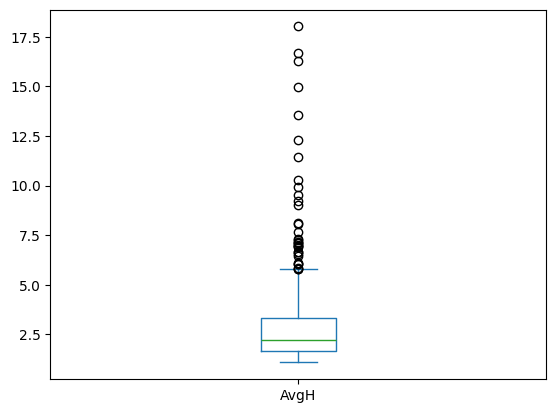

In [54]:
df['AvgH'].plot.box()


<Axes: >

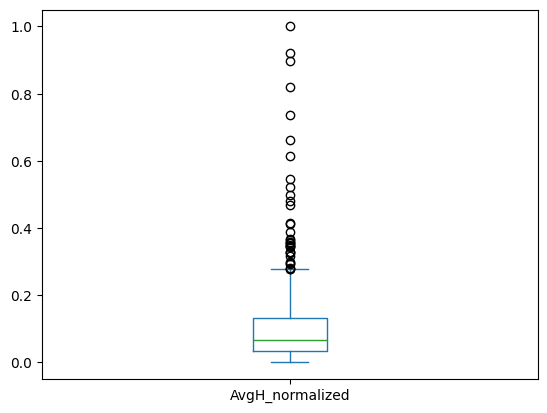

In [48]:
df['AvgH_normalized'].plot.box()

<Axes: >

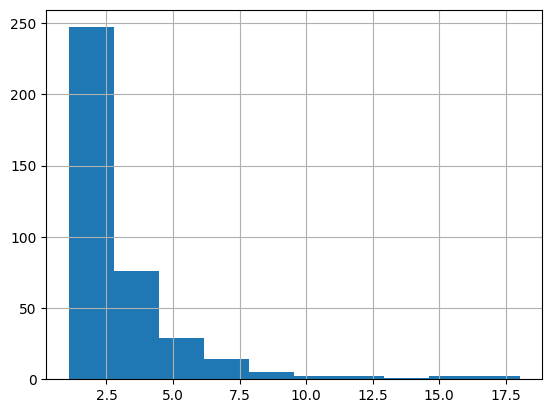

In [50]:
df['AvgH'].hist()

<Axes: >

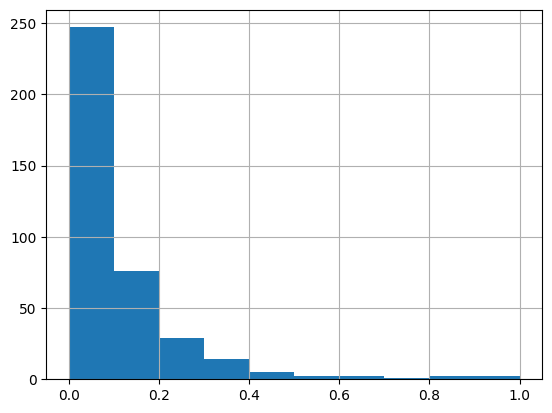

In [51]:
df['AvgH_normalized'].hist()

In [65]:
import numpy as np
from scipy.stats import median_abs_deviation

def detect_outliers_zscore_robust(data, threshold=3.5):
    if len(data) == 1:
        return np.array([False])
    
    median = np.median(data)
    mad = median_abs_deviation(data)
    z_scores = 0.6745 * (data - median) / mad
    outliers = np.abs(z_scores) > threshold
    return outliers

outliers = detect_outliers_zscore_robust(df['AvgH_normalized'])
print('Quantidade de outliers:', outliers.sum())

Quantidade de outliers: 31


<Axes: >

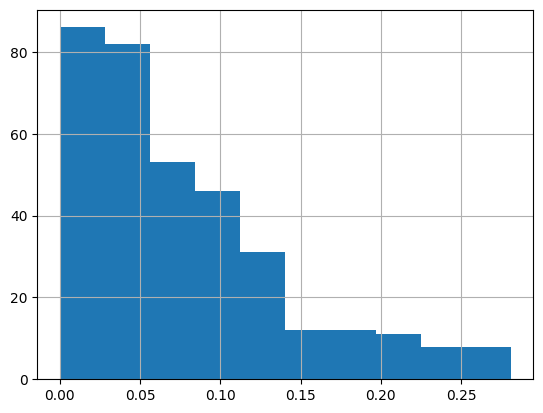

In [67]:
df_filtered = df[~outliers]
df_filtered['AvgH_normalized'].hist()

## Bivariado

,Column 1,Column 2,Correlation
0,AvgA,AvgA_normalized,1.000000
1,AvgA_normalized,AvgA,1.000000
2,AvgH_normalized,AvgH,1.000000
3,AvgH,AvgH_normalized,1.000000
4,AvgD,AvgD_normalized,1.000000
5,AvgD_normalized,AvgD,1.000000
6,AvgH_normalized,MaxH,0.998475
7,MaxH,AvgH_normalized,0.998475
8,MaxH,AvgH,0.998475
9,AvgH,MaxH,0.998475


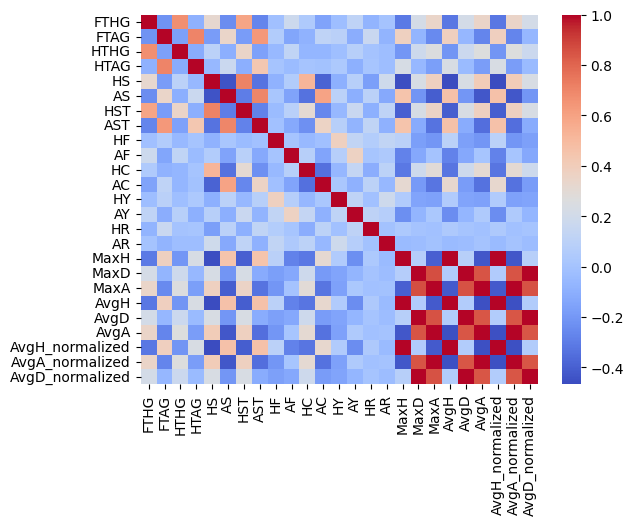

In [74]:
import seaborn as sns

# Selecionar apenas as colunas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Criar a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Plotar a matriz de correlação
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Identificar as colunas com o maior grau de correlação
max_correlation = correlation_matrix.abs().unstack().sort_values(ascending=False)
max_correlation = max_correlation[max_correlation < 1]  # Excluir a correlação perfeita (1.0)
max_correlation = max_correlation.reset_index()
max_correlation.columns = ['Column 1', 'Column 2', 'Correlation']
max_correlation.head(50)

<Axes: xlabel='HS', ylabel='HST'>

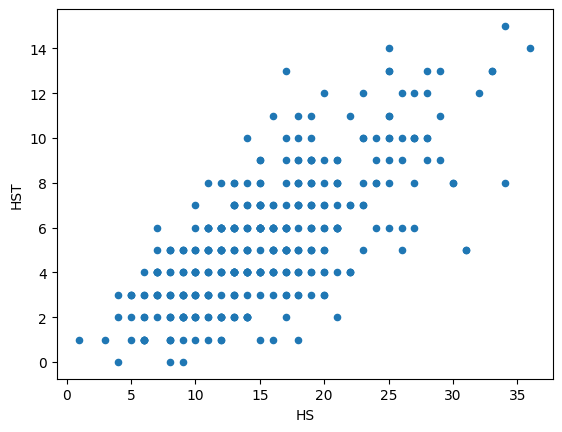

In [81]:
df.plot.scatter(x='HS', y='HST')

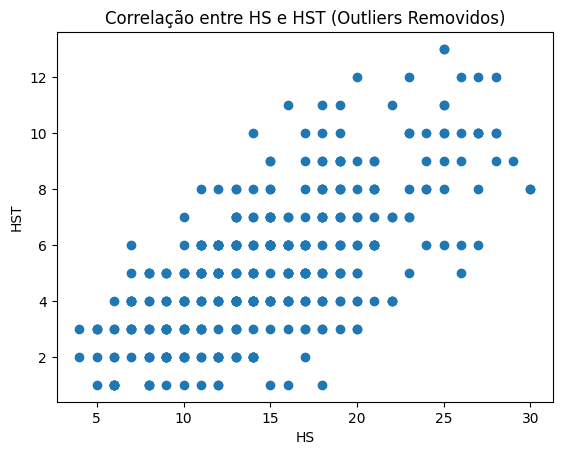

In [82]:
from sklearn.ensemble import IsolationForest

# Cria um novo DataFrame com as colunas 'HS' e 'HST'
df_corr = df[['HS', 'HST']]

# Instancia o modelo IsolationForest
model = IsolationForest(n_estimators=100, contamination=0.05)

# Ajusta o modelo aos dados
model.fit(df_corr)

# Obtém as previsões de outliers
outliers = model.predict(df_corr)

# Adiciona a coluna 'Outlier' ao DataFrame original
df['Outlier'] = outliers

# Remove as linhas onde 'Outlier' é igual a -1
df_filtered = df[df['Outlier'] != -1]

# Plota o gráfico de correlação entre 'HS' e 'HST' com os outliers removidos
plt.scatter(df_filtered['HS'], df_filtered['HST'])
plt.xlabel('HS')
plt.ylabel('HST')
plt.title('Correlação entre HS e HST (Outliers Removidos)')
plt.show()

<Axes: xlabel='HS', ylabel='HST'>

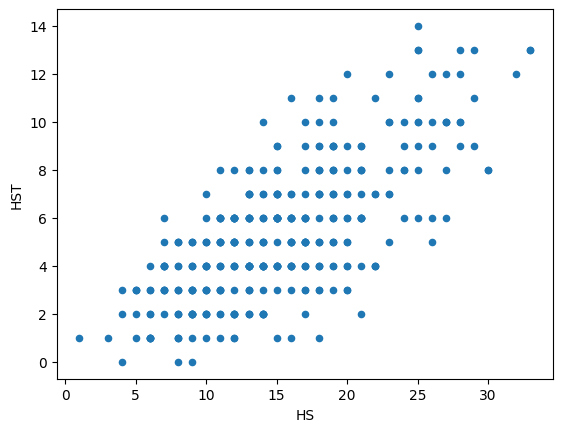

In [87]:
import numpy as np
from scipy.spatial.distance import mahalanobis

# Calcular a matriz de covariância
cov_matrix = np.cov(df[['HS', 'HST']].values.T)

# Calcular a matriz de inversa da covariância
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calcular a média dos pontos
mean = np.mean(df[['HS', 'HST']].values, axis=0)

# Calcular a distância de Mahalanobis para cada ponto
distances = []
for point in df[['HS', 'HST']].values:
    distance = mahalanobis(point, mean, inv_cov_matrix)
    distances.append(distance)

# Definir um limite para remover os outliers
limit = np.mean(distances) + 3 * np.std(distances)

# Remover os outliers
df_filtered = df[distances <= limit]

# Plotar o gráfico sem os outliers
df_filtered.plot.scatter(x='HS', y='HST')

# Análises

In [25]:
total_FTHG = df['FTHG'].sum()
total_FTAG = df['FTAG'].sum()

total_HTHG = df['HTHG'].sum()
total_HTAG = df['HTAG'].sum()

total_FTG = total_FTHG + total_FTAG
total_HTG = total_HTHG + total_HTAG

print("Total Full Time Goals: ", total_FTG)
print("Total Half Time Goals: ", total_HTG)



Total Full Time Goals:  1246
Total Half Time Goals:  517


In [ ]:
df['GoalDifferenceFT'] = df['FTHG'] - df['FTAG']
df['GoalDifferenceHT'] = df['HTHG'] - df['HTAG']

# Ideias de predições:
Vencedor de acordo com o placar do primeiro tempo.
Gols feitos por quantidade de chutes/chutes ao alvo.



In [5]:
percentage_h = (df['FTR'].value_counts()['H'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'H' na coluna 'FTR' é de {percentage_h:.2f}%")

percentage_d = (df['FTR'].value_counts()['D'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'D' na coluna 'FTR' é de {percentage_d:.2f}%")

percentage_a = (df['FTR'].value_counts()['A'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'A' na coluna 'FTR' é de {percentage_a:.2f}%")



A porcentagem de valores 'H' na coluna 'FTR' é de 46.05%
A porcentagem de valores 'D' na coluna 'FTR' é de 21.58%
A porcentagem de valores 'A' na coluna 'FTR' é de 32.37%


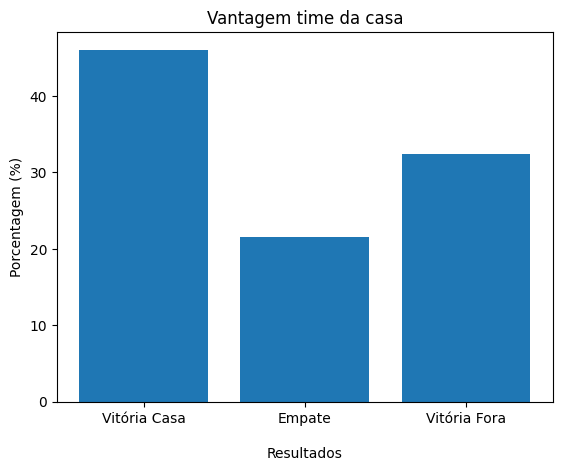

In [26]:
plt.bar(['Vitória Casa', 'Empate', 'Vitória Fora'], [percentage_h, percentage_d, percentage_a])
plt.xlabel('\nResultados')
plt.ylabel('Porcentagem (%)')
plt.title('Vantagem time da casa')
plt.show()

In [27]:
df['ExpectedResult'] = df[['B365H', 'B365D', 'B365A']].idxmin(axis=1)

mapping = {'B365H': 'H', 'B365D': 'D', 'B365A': 'A'}
df['ExpectedResult'] = df['ExpectedResult'].map(mapping)

matches = (df['ExpectedResult'] == df['FTR']).sum()

print(f"O time favorito venceu {matches} partidas de {len(df)} possíveis")

O time favorito venceu 227 partidas de 380 possíveis


In [28]:
def calculate_amount(row):
    odds_mapping = {'H': 'B365H', 'A': 'B365A', 'D': 'B365D'}

    if row['ExpectedResult'] == row['FTR']:
        return row[odds_mapping[row['ExpectedResult']]]
    else:
        return 0



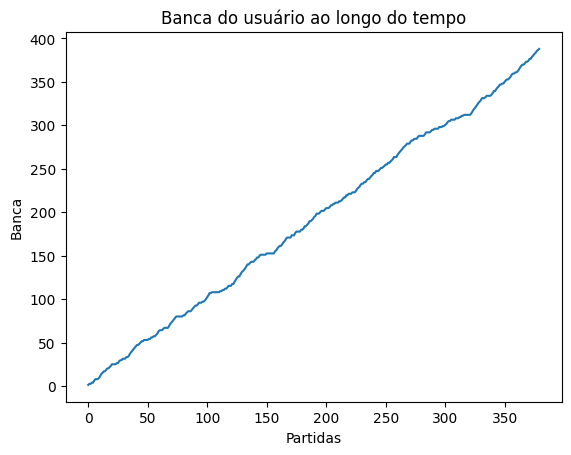

O usuário realizou 380 apostas.
O usuário ganhou 7.779999999999973 reais.


In [29]:
df['amount'] = df.apply(calculate_amount, axis=1)

# Calculate the cumulative sum of the amounts to get the user's balance after each match
df['cumulative_amount'] = df['amount'].cumsum()

# Plot the user's balance over time
plt.plot(df['cumulative_amount'])
plt.xlabel('Partidas')
plt.ylabel('Banca')
plt.title('Banca do usuário ao longo do tempo')
plt.show()

print(f"O usuário realizou {len(df['cumulative_amount'])} apostas.")
print(f"O usuário ganhou {df['amount'].sum()-len(df['cumulative_amount'])} reais.")